# Introduction
This repository contains the codebase for an advanced video analysis pipeline that combines the power of multiple state-of-the-art models and methodologies including YOLO V8, ByteTrack, Movenet, and Transformer encoders for high-accuracy activity recognition. The pipeline is trained on the Human Activity Recognition (HAR - Video Dataset)

Reference:
Datasets: https://www.kaggle.com/datasets/sharjeelmazhar/human-activity-recognition-video-dataset?resource=download-directory

In [1]:
!python -V

Python 3.10.13


In [2]:
!nvidia-smi

Wed Oct 18 11:44:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   42C    P3    22W / 130W |   1413MiB /  8192MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



# Install Dependencies

In [ ]:
!pip install --upgrade pip
!pip install tensorflow==2.12.0
!pip install torch
!pip install torchvision
!pip install opencv-python-headless
!pip install numpy==1.23.5
!pip install opencv-python

!pip install imageio
!pip install opencv-python
!pip install git+https://github.com/tensorflow/docs
!pip install git+https://github.com/huggingface/transformers

!pip install timm
!pip install scikit-learn 
!pip install keras

!pip install matplotlib>=3.3.0
!pip install opencv-python>=4.6.0
!pip install pillow>=7.1.2
!pip install pyyaml>=5.3.1
!pip install requests>=2.23.0
!pip install scipy>=1.4.1
!pip install torch>=1.8.0
!pip install torchvision>=0.9.0
!pip install tqdm>=4.64.0

!pip install pandas>=1.1.4
!pip install seaborn>=0.11.0

!pip install psutil
!pip install py-cpuinfo
!pip install openpyxl
!pip install thop>=0.1.1
!pip install ultralytics

#  Import Dependencies

In [3]:
# Standard Library Imports
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import tensorflow as tf
import numpy as np
import random
import gc
gc.enable()

# Third-party Libraries
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Custom Module Imports
from train import initialize_dense_model, initialize_lstm_model, initialize_cnn_model, train_model
from datasets import create_datasets, create_cnn_datasets

# Constants or Configuration
from torchvision.models.resnet import ResNet152_Weights

Ultralytics YOLOv8.0.199  Python-3.10.13 torch-2.0.0+cpu CPU (AMD Ryzen 5 5600X 6-Core Processor)
Setup complete  (12 CPUs, 31.9 GB RAM, 438.6/465.0 GB disk)


In [4]:
import os
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

SEQUENCE_LENGTH = 50

# Datasets
DATASET_DIR = 'C:/Users/Duc Anh/Desktop/Activity-Recogntion/datasets/Human Activity Recognition - Video Dataset'
CLASSES_LIST = sorted([entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir()])
print(CLASSES_LIST)

# Setting Up Saving Folder
final = "C:/Users/Duc Anh/Desktop/Activity-Recogntion/final"
if not os.path.exists(final):
    os.makedirs(final)
%cd "C:/Users/Duc Anh/Desktop/Activity-Recogntion/final"

['Clapping', 'Meet and Split', 'Sitting', 'Standing Still', 'Walking', 'Walking While Reading Book', 'Walking While Using Phone']
C:\Users\Duc Anh\Desktop\Activity-Recogntion\final


# Initialize Model


In [7]:
# Initialize YOLO model
yolo_model = YOLO('yolov8x.pt')
# yolo_model.to(torch.device("cuda"))

# For spatial features
spatial_resnet = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
spatial_resnet = nn.Sequential(*list(spatial_resnet.children())[:-1])
spatial_resnet.eval()

# For temporal features
temporal_resnet = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
temporal_resnet = nn.Sequential(*list(temporal_resnet.children())[:-1])
temporal_resnet.eval()


# Define Transformer Encoders
# fewer attention heads for spatial model
spatial_encoder_layers = TransformerEncoderLayer(d_model=2048, nhead=4)  # fewer attention heads for spatial model
spatial_transformer = TransformerEncoder(spatial_encoder_layers, num_layers=2)

# more attention heads for temporal model
temporal_encoder_layers = TransformerEncoderLayer(d_model=2048, nhead=16)  # more attention heads for temporal model
temporal_transformer = TransformerEncoder(temporal_encoder_layers, num_layers=2)

# Data Pre-processing

In [8]:
# Datasets for Dense + LSTM
create_datasets_pth = "C:/Users/Duc Anh/Desktop/Activity-Recogntion/final/create_datasets"
if not os.path.exists(create_datasets_pth):
    os.makedirs(create_datasets_pth)
%cd "C:/Users/Duc Anh/Desktop/Activity-Recogntion/final/create_datasets"
# Preparing Datasets for Training
dl_features, dl_labels, dl_video_files_paths = create_datasets(yolo_model,
                                                      spatial_resnet,
                                                      spatial_transformer,
                                                      temporal_resnet,
                                                      temporal_transformer,
                                                      DATASET_DIR,
                                                      CLASSES_LIST,
                                                      SEQUENCE_LENGTH,
                                                      NUM_VIDEOS_TO_PROCESS=25)

# Drop any NaN
if np.isnan(dl_features).any():
  # Identify sequences that contain any nan values
  sequences_with_nan = np.any(np.isnan(dl_features), axis=(1, 2))

  # Filter out those sequences
  dl_features = dl_features[~sequences_with_nan]
  dl_labels = dl_labels[~sequences_with_nan]

  print(f"Original number of sequences: {dl_features.shape[0]}")
  print(f"Number of sequences after removal: {dl_labels.shape[0]}")
  print(f'{dl_features.shape}')
  print(f'{dl_labels.shape}')

# Data Augmented, this might be a good testing to scale the datasets for training
from datasets import augment_features
# Generate the augmented data
all_augmented_features = augment_features(dl_features)

# Combine original and all augmented versions
all_features = np.concatenate((dl_features, all_augmented_features), axis=0)

# # Create labels for the augmented data
all_labels = np.tile(dl_labels, (all_features.shape[0] // dl_features.shape[0],))

from tensorflow.keras.utils import to_categorical
dl_one_hot_encoded_labels = to_categorical(all_labels)
dl_features_train, dl_features_test, dl_labels_train, dl_labels_test = train_test_split(all_features, all_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

C:\Users\Duc Anh\Desktop\Activity-Recogntion\final\create_datasets
Final data already exists. Loading and skipping further processing...
Features shape: (160,)
Labels shape: (160,)

Features shape: (160, 50, 4096)
Labels shape: (160,)
Original number of sequences: 158
Number of sequences after removal: 158
(158, 50, 4096)
(158,)


In [ ]:
# Datasets for CNN Model
create_cnn_datasets_pth = "C:/Users/Duc Anh/Desktop/Activity-Recogntion/final/create_cnn_datasets"
if not os.path.exists(create_datasets_pth):
    os.makedirs(create_datasets_pth)
%cd "C:/Users/Duc Anh/Desktop/Activity-Recogntion/final/create_cnn_datasets"
cnn_features, cnn_labels, cnn_video_files_paths = create_cnn_datasets(DATASET_DIR,
                                                         CLASSES_LIST,
                                                         SEQUENCE_LENGTH,
                                                         NUM_VIDEOS_TO_PROCESS=2)

# Drop any NaN
if np.isnan(cnn_features).any():
  # Identify sequences that contain any nan values
  sequences_with_nan = np.any(np.isnan(cnn_features), axis=(1, 2))

  # Filter out those sequences
  cnn_features = cnn_features[~sequences_with_nan]
  cnn_labels = cnn_labels[~sequences_with_nan]

  print(f"Original number of sequences: {cnn_features.shape[0]}")
  print(f"Number of sequences after removal: {cnn_labels.shape[0]}")
  print(f'{cnn_features.shape}')
  print(f'{cnn_labels.shape}')

from tensorflow.keras.utils import to_categorical
# cnn_one_hot_encoded_labels = to_categorical(cnn_labels)
# Please run this if you want to split the data without Augment!
cnn_features_train, cnn_features_test, cnn_labels_train, cnn_labels_test = train_test_split(cnn_features, cnn_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

In [9]:
print('Dense + LSTM')
print(f'Features Train: {dl_features_train.shape}')
print(f'Labels Train: {dl_labels_train.shape}')
print(f'Features Test: {dl_features_test.shape}')
print(f'Labels Test: {dl_labels_test.shape}\n')

Dense + LSTM
Features Train: (884, 50, 4096)
Labels Train: (884,)
Features Test: (222, 50, 4096)
Labels Test: (222,)



In [ ]:
print('CNN')
print(f'Features Train: {cnn_features_train.shape}')
print(f'Labels Train: {cnn_labels_train.shape}')
print(f'Features Test: {cnn_features_test.shape}')
print(f'Labels Test: {cnn_labels_test.shape}')

# Model Training

In [10]:
%cd "C:/Users/Duc Anh/Desktop/Activity-Recogntion/final/"

C:\Users\Duc Anh\Desktop\Activity-Recogntion\final


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 512)               104858112 
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

Epoch 19/1000000000000
23/23 [==============================] - ETA: 0s - loss: 7.0616 - accuracy: 0.5262
Epoch 19: val_loss did not improve from 6.15419
23/23 [==============================] - 16s 712ms/step - loss: 7.0616 - accuracy: 0.5262 - val_loss: 6.9883 - val_accuracy: 0.6780 - lr: 1.0000e-06
Epoch 20/1000000000000
23/23 [==============================] - ETA: 0s - loss: 7.0567 - accuracy: 0.5545
Epoch 20: val_loss did not improve from 6.15419
23/23 [==============================] - 16s 710ms/step - loss: 7.0567 - accuracy: 0.5545 - val_loss: 6.9884 - val_accuracy: 0.6780 - lr: 1.0000e-06
Epoch 21/1000000000000
23/23 [==============================] - ETA: 0s - loss: 7.0878 - accuracy: 0.5474Restoring model weights from the end of the best epoch: 1.

Epoch 21: val_loss did not improve from 6.15419
23/23 [==============================] - 17s 722ms/step - loss: 7.0878 - accuracy: 0.5474 - val_loss: 6.9921 - val_accuracy: 0.6667 - lr: 1.0000e-06
Epoch 21: early stopping


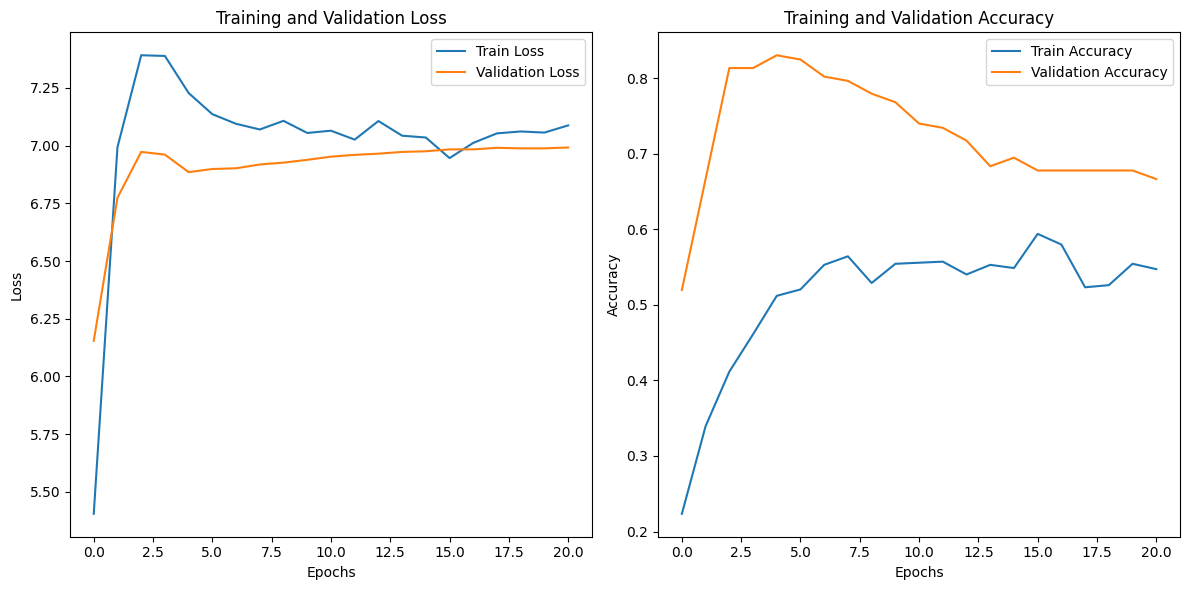

In [11]:
input_shape = (dl_features.shape[1], dl_features.shape[2])
num_classes = len(CLASSES_LIST)

# Dense Model
dense_model = initialize_dense_model(input_shape, num_classes)
dense_model.summary()
# Train model
dense_model_name = 'dense_model'
dense_model = train_model(dense_model_name, 
                          dense_model, 
                          dl_features_train, 
                          dl_labels_train, 
                          batch_size=32, 
                          epochs=1000000000000, 
                          early_stopping_patience=20)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 1024)          20975616  
                                                                 
 dropout_3 (Dropout)         (None, 50, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 512)           3147776   
                                                                 
 dropout_4 (Dropout)         (None, 50, 512)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

23/23 [==============================] - 47s 2s/step - loss: 1.8621 - accuracy: 0.8246 - val_loss: 1.8413 - val_accuracy: 0.7966 - lr: 2.0000e-04
Epoch 17/1000000000000
23/23 [==============================] - ETA: 0s - loss: 1.8545 - accuracy: 0.8458
Epoch 17: val_loss did not improve from 1.84132
23/23 [==============================] - 48s 2s/step - loss: 1.8545 - accuracy: 0.8458 - val_loss: 1.9636 - val_accuracy: 0.8136 - lr: 2.0000e-04
Epoch 18/1000000000000
23/23 [==============================] - ETA: 0s - loss: 1.8467 - accuracy: 0.8444
Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 18: val_loss did not improve from 1.84132
23/23 [==============================] - 47s 2s/step - loss: 1.8467 - accuracy: 0.8444 - val_loss: 1.9190 - val_accuracy: 0.8136 - lr: 2.0000e-04
Epoch 19/1000000000000
23/23 [==============================] - ETA: 0s - loss: 1.8356 - accuracy: 0.8402
Epoch 19: val_loss did not improve from 1.84132
23/23 [==============

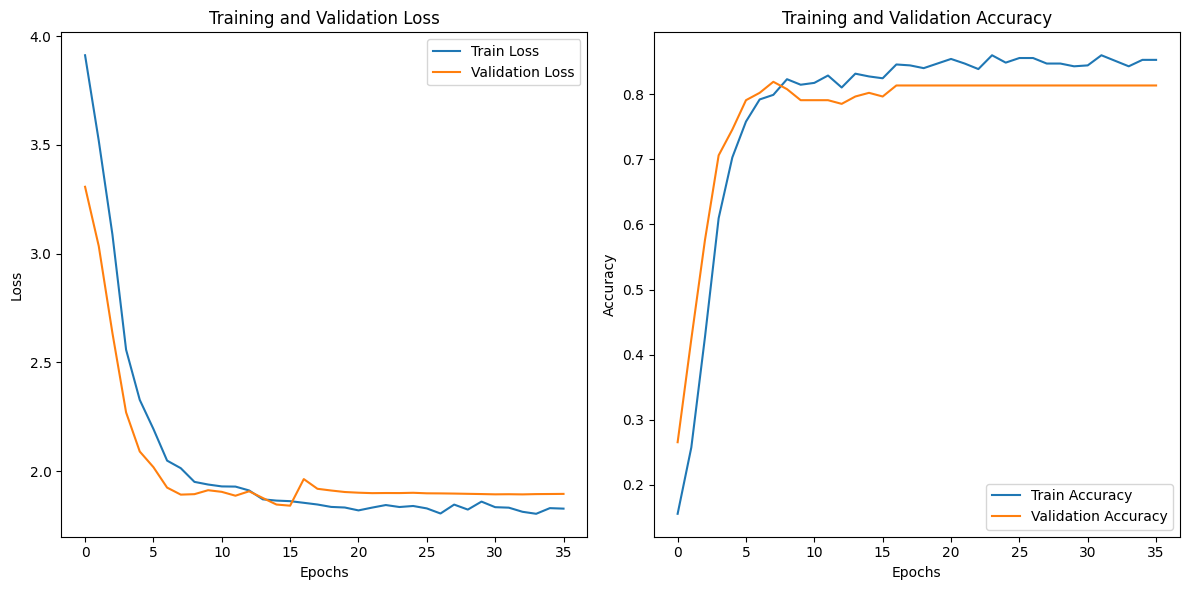

In [12]:
input_shape = (dl_features.shape[1], dl_features.shape[2])
num_classes = len(CLASSES_LIST)

# LSTM MODEL
lstm_model = initialize_lstm_model(input_shape, num_classes)
lstm_model.summary()

# Train model
lstm_model_name = 'lstm_model'
lstm_model = train_model(lstm_model_name, 
                         lstm_model, 
                         dl_features_train, 
                         dl_labels_train,  
                         batch_size=32, 
                         epochs=1000000000000, 
                         early_stopping_patience=20)

In [ ]:
input_shape = (cnn_features.shape[1], cnn_features.shape[2], cnn_features.shape[3], cnn_features.shape[4])
num_classes = len(CLASSES_LIST)

# CNN Model
cnn_model = initialize_cnn_model(input_shape, num_classes)
cnn_model.summary()


# Train model
cnn_model_name = 'cnn_model'
cnn_model = train_model(cnn_model_name, 
                         cnn_model, 
                         cnn_features_train, 
                         cnn_labels_train, 
                         batch_size=4, 
                         epochs=1000000000000, 
                         early_stopping_patience=20)